Integrantes:

* Juan Carlos Sánchez
* Nicolás Eduardo Pardo
* David Esteban Casallas


# Tarea 3 Cadenas de Markov

### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Punto 1 a)

Para el punto 1. parte a) vamos a crear un generador MCMC de muestras para el modelo de Ising. Vamos entonces a explicar un poco el proceso antes de mostrar el código.


## Modelo de Ising y MCMC

El **modelo de Ising** es un modelo físico utilizado para describir sistemas de espines magnéticos en la mecánica estadística. Consiste en una red de espines (normalmente en una estructura bidimensional o tridimensional), donde cada espín puede estar en uno de dos estados posibles: +1 o -1, que representan los dos estados magnéticos (arriba o abajo).

La energía del sistema se describe por la siguiente **Hamiltoniana**:

$$
H = -J \sum_{\langle i,j \rangle} s_i s_j - \mu \sum_i s_i h_i
$$

Donde:
- $H$ es la energía total del sistema.
- $J$ es la constante de interacción (representa la fuerza con la que interactúan los espines).
- $s_i$ es el estado del espín en el sitio $i$ (puede ser +1 o -1).
- $\langle i,j \rangle$ indica que estamos sumando sobre pares vecinos de espines $i$ y $j$.
- $\mu$ es el momento magnético.
- $h_i$ es el campo magnético externo aplicado en el sitio $i$.

### Algoritmo de MCMC (Monte Carlo basado en Cadenas de Markov)

Para generar muestras del modelo de Ising, usamos el algoritmo MCMC, específicamente el **algoritmo de Metropolis-Hastings**. Este método nos permite explorar el espacio de estados del sistema, simulando configuraciones de espines de acuerdo a la distribución de probabilidad de Boltzmann:

$$
P(s) \propto \exp(-\beta H(s))
$$

Donde:
- $P(s)$ es la probabilidad de la configuración $s$.
- $\beta = \frac{1}{k_B T}$, donde $k_B$ es la constante de Boltzmann y $T$ es la temperatura.

### Pasos del algoritmo de Metropolis-Hastings:
1. Inicializar los espines en una configuración aleatoria.
2. Elegir un espín $s_i$ al azar y calcular el cambio de energía $\Delta E$ si este espín cambia de estado.
3. Si $\Delta E \leq 0$, cambiar el estado del espín (es favorable reducir la energía).
4. Si $\Delta E > 0$, aceptar el cambio con una probabilidad $p = \exp(-\beta \Delta E)$.
5. Repetir este proceso para un gran número de pasos hasta que el sistema alcance el equilibrio.

Al final de este proceso, las configuraciones generadas siguen la distribución de Boltzmann, lo que permite estimar propiedades físicas como la magnetización, la energía media, etc.


In [ ]:
class IsingModel:

    def __init__(self, k, betas):
        self.k = k  # Tamaño del lattice
        self.betas = betas  # Lista con las temperaturas inversas (Beta)
        self.lattice = np.random.choice([-1, 1], size=(k, k))  # Generamos un lattice aleatorio con 1s y -1s

    def energy_change(self, i, j): # Definimos una función para calcular el cambio de energia cuando se cambia la rotación en un vertice
        spin = self.lattice[i, j]

        neighbors = self.lattice[(i+1) % self.k, j] + self.lattice[(i-1) % self.k, j] + self.lattice[i, (j+1) % self.k] + self.lattice[i, (j-1) % self.k] # Calculamos el cambio de energía con la formula
        return 2 * spin * neighbors

    def metropolis_step(self, beta): # Realizamos un paso de Metropolis-Hastings con una temperatura inversa Beta
        for w in range(self.k**2):
            i, j = np.random.randint(0, self.k, size=2)  # Seleccionamos un vertice aleatorio
            delta_E = self.energy_change(i, j)  # Calculamos el cambio de energía si cambia el giro

            if delta_E < 0 or np.random.rand() < np.exp(-beta * delta_E):  # La condición para cambiar el giro
                self.lattice[i, j] *= -1  # Cambiamos el giro

    def generate_samples(self, num_samples=100, thermalization_steps=1000):

        samples = [] #Lista de muestras
        for beta in self.betas:

            for i in range(thermalization_steps): #Primero realizamos los pasos
                self.metropolis_step(beta)

            for i in range(num_samples): #Luego generamos las muestras
                self.metropolis_step(beta)
                samples.append(self.lattice.copy())
        return samples

Ahora vamos a generar las muestras, vamos a utilizar $k = 10$ pues para el algoritmo de Propp-Wilson hemos tenido tiempos de ejecución muy largos. Aún así note que este código funciona para valores de $k$ más altos.

In [ ]:
k = 10  # Tamaño del latice
betas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # Valores de temperatura inversa
num_samples = 100  # Numero de muestras por beta
thermalization_steps = 10000 # Pasos de MCMC multiplicado por k*k, es decir si pongo 1000 en realidad son 1000*10*10 = 100000

ising_model = IsingModel(k, betas) # Generamos una instancia del modelo de Ising

samples = ising_model.generate_samples(num_samples=num_samples, thermalization_steps=thermalization_steps ) # Generamos las muestras usando MCMC

Con esta función podemos gráficar las muestras, funciona para ambos algoritmos ya que las muestras resultantes son del mismo formato.

In [ ]:
def plot_samples_from_betas(samples, betas, k, num_samples):
    num_betas = len(betas)
    plt.figure(figsize=(20, 10))

    # Gráficamos una muestra por beta
    for i, beta in enumerate(betas):
        sample_index = i * num_samples
        plt.subplot(1, num_betas, i+1)
        plt.imshow(samples[sample_index], cmap='gray')
        plt.title(f'Beta={beta}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

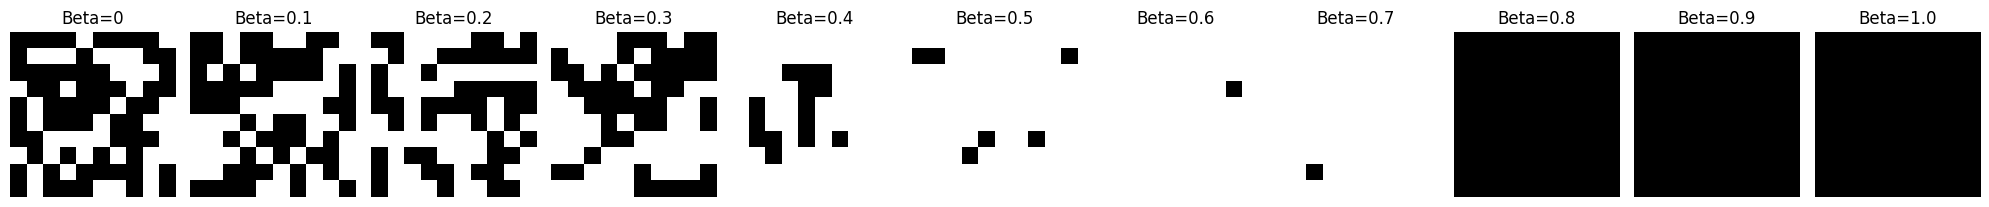

In [ ]:
plot_samples_from_betas(samples, betas, k, num_samples)

## Punto 1 b)

## Algoritmo de Propp-Wilson con Sandwiching aplicado al Modelo de Ising

El **algoritmo de Propp-Wilson** es un método de muestreo perfecto que se usa para generar muestras exactas de distribuciones estacionarias, como las del modelo de Ising. A diferencia del MCMC estándar, este algoritmo no depende de un estado inicial arbitrario, ya que garantiza que la muestra generada proviene directamente de la distribución de equilibrio. Para lograr esto, el algoritmo se basa en la idea de "sandwiching" y la técnica de **acoplamiento desde el pasado** (Coupling from the Past, CFTP).

### Conceptos Clave

- **Acoplamiento desde el pasado (CFTP)**: Se hace evolucionar el sistema desde el pasado de tal manera que las trayectorias de todas las posibles configuraciones de espines converjan en un único estado, lo que asegura que la muestra generada sea de la distribución de equilibrio.
  
- **Sandwiching**: Se utiliza un conjunto superior y un conjunto inferior de configuraciones extremas, que en el caso del modelo de Ising corresponden a todas las espines en $+1$ (estado ferromagnético saturado) y todas las espines en $-1$ (estado antiferromagnético saturado). A medida que el sistema evoluciona hacia el presente, los dos conjuntos se van "sandwicheando" o estrechando, hasta que se encuentran en una misma configuración.

### Pasos del Algoritmo

1. **Inicializar los extremos**:
    - Configuración superior: Todas las espines en $+1$.
    - Configuración inferior: Todas las espines en $-1$.
    
2. **Evolución hacia el pasado**:
   Se elige un tiempo $T$ en el pasado. Desde ese punto, se aplican actualizaciones estocásticas (usualmente utilizando el algoritmo de Metropolis-Hastings o Glauber dynamics) a todas las configuraciones posibles de espines hacia el presente.

3. **Actualización**: Para cada paso de tiempo, se actualizan las configuraciones superiores e inferiores utilizando la misma secuencia de aleatoriedad. Si en algún momento, las dos configuraciones extremas se "acoplan", es decir, se encuentran en la misma configuración en el tiempo $t=0$, entonces se ha alcanzado el estado estacionario.

4. **Condición de parada**: Si las configuraciones superior e inferior son iguales en el tiempo $t=0$, el sistema ha alcanzado su configuración estacionaria, y esa configuración es una muestra perfecta de la distribución de Boltzmann del modelo de Ising.

### Fórmulas y Cálculo

La probabilidad de actualización de un espín $s_i$ sigue las mismas reglas que en el algoritmo de Metropolis-Hastings. El cambio de energía $\Delta E$ al cambiar el espín $s_i$ se calcula como:

$$
\Delta E = 2 s_i \left( J \sum_{j \in \text{vecinos}(i)} s_j + h_i \right)
$$

Donde:
- $s_i$ es el espín en la posición $i$.
- $J$ es la constante de interacción.
- $h_i$ es el campo magnético externo en el sitio $i$.

La probabilidad de aceptar el cambio de espín se define como:

$$
P(\text{aceptar}) = \min(1, \exp(-\beta \Delta E))
$$

Donde:
- $\beta = \frac{1}{k_B T}$.

Cuando ambos límites (superior e inferior) coinciden en la misma configuración, esa configuración es una muestra perfecta del sistema de espines en equilibrio térmico.

### Ventajas del Algoritmo de Propp-Wilson
El algoritmo Propp-Wilson con acoplamiento desde el pasado es muy eficiente cuando se necesita una muestra exacta de la distribución de equilibrio del sistema. Sin embargo, es computacionalmente más costoso que el MCMC simple, ya que requiere el seguimiento simultáneo de múltiples configuraciones y una evolución hacia el pasado.

Este algoritmo es especialmente útil en sistemas donde las transiciones entre estados tienen un coste alto o cuando se desea evitar el sesgo introducido por la inicialización arbitraria de los espines.



In [ ]:
class IsingModelProppWilson:

    def __init__(self, k, betas):
        self.k = k  # Tamaño del lattice
        self.betas = betas  # Lista de temperaturas inversas (beta)

    def energy_change(self, lattice, i, j): # Calculamos el cambio de energia al cambiar el giro de un vertice
        spin = lattice[i, j]

        neighbors = lattice[(i+1) % self.k, j] + lattice[(i-1) % self.k, j] + lattice[i, (j+1) % self.k] + lattice[i, (j-1) % self.k] # Calculamos la energia usando la formula
        return 2 * spin * neighbors

    def metropolis_step(self, lattice, beta, random_numbers): # Realizamos un paso de Metropolis-Hastings con una temperatura inversa Beta
        for i in range(self.k):
            for j in range(self.k):
                delta_E = self.energy_change(lattice, i, j)
                if delta_E < 0 or random_numbers[i, j] < np.exp(-beta * delta_E):  # La condición para cambiar el giro
                    lattice[i, j] *= -1 # Cambiamos el giro
        return lattice

    def propp_wilson(self, beta, max_iterations=1000): # Realizamos el algoritmo de Propp-Wilson con sandwiching para obtener una muestra exacta usando beta

        lower = -np.ones((self.k, self.k))  # Minimal, todo en -1
        upper = np.ones((self.k, self.k))   # Maximal, todo en +1


        random_numbers = [np.random.rand(self.k, self.k) for i in range(max_iterations)] # Guardamos los valores usados para las simulaciones

        for t in reversed(range(max_iterations)):

            lower = self.metropolis_step(lower, beta, random_numbers[t]) # Realizamos un paso de metropolis para la cota superior e inferior
            upper = self.metropolis_step(upper, beta, random_numbers[t])


            if np.array_equal(lower, upper): # Si ambas cotas coinciden signifca que tenemos coalescencia
                return upper, t

            if beta == 0: # Si el valor de la energía es 0 cualquier valor aleatorio nos funciona, así que mejor no correr todos los pasos
                return upper, t


        return upper, max_iterations # De igual forma acotamos los tiempos para no permanecer esperando la coalescencia un tiempo indefinido

    def generate_samples(self, num_samples=100, max_iterations=10000):

        samples = [] # Lista para guardar las muestras
        coalings = [] # Lista de tiempo de coalición
        for beta in self.betas:
            print("Ejcutando para beta = ", beta)
            for i in range(num_samples):
                sample, coaling = self.propp_wilson(beta, max_iterations) # Ejecutamos Propp Wilson
                samples.append(sample)
                coalings.append(coaling)
        return samples, coalings

Vamos entonces a ejecutar este algoritmo con $k = 10$ y note de todas formas que para el tiempo de coalición tenemos una cota, nos tocó colocar esto pues para algunos valores de energía el programa tarda demasiado en coincidir las cotas, de hecho note que para energía 0 cualquier muestra aleatoria funciona.

In [ ]:
k = 10  # Tamaño del lattice
betas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # Valores de la temperatura inversa (beta)
num_samples = 100  # Numero de muestras

ising_model_pw = IsingModelProppWilson(k, betas) # Creamos una instancia

samples_pw, coalings = ising_model_pw.generate_samples(num_samples=num_samples) # Generamos las muestras

Ejcutando para beta =  0
Ejcutando para beta =  0.1
Ejcutando para beta =  0.2
Ejcutando para beta =  0.3
Ejcutando para beta =  0.4
Ejcutando para beta =  0.5
Ejcutando para beta =  0.6
Ejcutando para beta =  0.7
Ejcutando para beta =  0.8
Ejcutando para beta =  0.9
Ejcutando para beta =  1.0


Con esta ejecución acotada en 10000 pasos note que tardamos 2 horas en completar todo el proceso, aún así más adelante veremos que el tiemplo de coalición es el mismo que el de la cota, es decir no hubo coalecencia. Aún así este código se ejecutó tambien con una cota de un millón y en 2 días completos nunca terminó de ejecutarse.

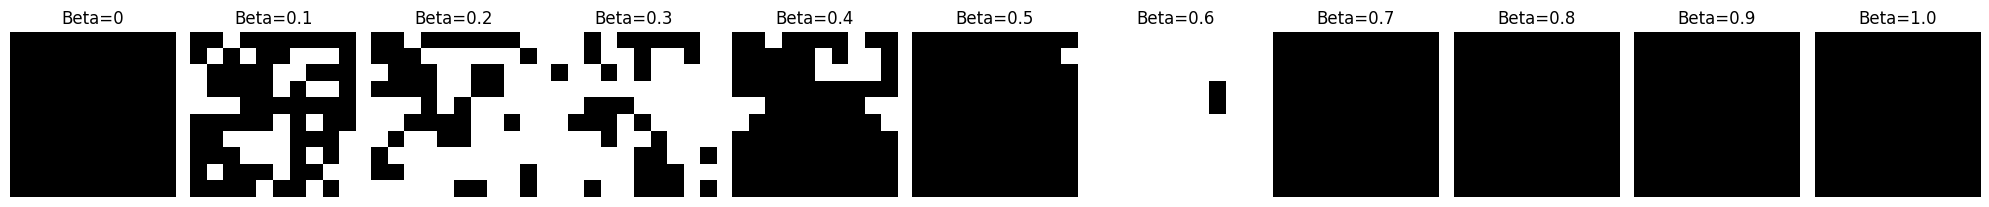

In [ ]:
plot_samples_from_betas(samples_pw, betas, k, num_samples)

Note sin embargo que las muestras obtenidas no varian demasiado de MCMC a excepción de algunas betas pero esto probablemente se debe a que por usar sandwiching nuestro resultado siempre será más cercano al maximal, a diferencia del MCMC que empieza de una matríz aleatoria.

## Punto 1 c)

## Cálculo del Magnetismo en el Modelo de Ising y Valor Esperado

En el **modelo de Ising**, el magnetismo mide la tendencia de los espines a alinearse en una dirección específica (arriba o abajo). El magnetismo total de una configuración de espines $s = \{s_1, s_2, \dots, s_N\}$, donde $N$ es el número total de espines, se calcula como la suma de los valores de los espines en toda la red:

$$
M(s) = \sum_{i=1}^{N} s_i
$$

Donde:
- $M(s)$ es el magnetismo de la configuración $s$.
- $s_i \in \{-1, +1\}$ es el espín en el sitio $i$.
- $N$ es el número total de espines en la red.

El magnetismo total puede ser positivo o negativo dependiendo de cuántos espines estén alineados en la misma dirección. El valor de $M(s)$ proporciona una medida global del estado magnético del sistema: si $M(s) \approx N$, casi todos los espines están alineados en la misma dirección, mientras que si $M(s) \approx 0$, el sistema está desordenado y hay una mezcla de espines hacia arriba y hacia abajo.

### Valor Esperado del Magnetismo

Para estimar el **valor esperado del magnetismo** a partir de una serie de configuraciones generadas por algún método de muestreo (como MCMC o Propp-Wilson), calculamos el promedio del magnetismo en una serie de muestras. Si generamos $k$ configuraciones de espines $\{s^{(1)}, s^{(2)}, \dots, s^{(k)}\}$, el valor esperado del magnetismo $\langle M \rangle$ se aproxima como:

$$
\langle M \rangle = \frac{1}{k} \sum_{j=1}^{k} M(s^{(j)})
$$

Donde:
- $M(s^{(j)})$ es el magnetismo de la configuración $s^{(j)}$.
- $k$ es el número total de muestras (en este caso, 100).

### Procedimiento para Estimar el Magnetismo con 100 Muestras

1. **Generar 100 configuraciones de espines**: Usando un método como MCMC o Propp-Wilson, se generan 100 configuraciones independientes del sistema de Ising.
  
2. **Calcular el magnetismo para cada muestra**: Para cada configuración $s^{(j)}$, se calcula $M(s^{(j)})$ usando la fórmula del magnetismo total.

3. **Calcular el valor esperado del magnetismo**: Se promedia el magnetismo de todas las configuraciones generadas.

In [ ]:
def calculate_magnetization(sample):
    return np.sum(sample) / (sample.shape[0] * sample.shape[1]) # Calculamos la magnetización de la muestra

def expected_magnetization(samples):
    magnetizations = [calculate_magnetization(sample) for sample in samples] # Guardamos las magnetizaciones y luego promediamos
    return np.mean(magnetizations)

def magnetization_per_beta(samples, betas, num_samples):
  l = len(betas) # Cuantas betas tenemos
  expecteds = [] # Guardamos los valores esperados por cada beta
  for i in range(l):
    expecteds.append(expected_magnetization(samples[i*num_samples:(i+1)*num_samples])) # Hay una cantidad de num_samples por beta
  return expecteds


Luego de calcular el magnetismo vamos a promediarlo por beta para calcular el valor esperado dependiente de beta, y finalmente podemos graficar los valores esperados según los algoritmos.

In [ ]:
def graph_versus(samples1, samples2, betas):

  df = pd.DataFrame({'MCMC':samples1, 'Propp Wilson':samples2, 'Beta': betas}) #Guardamos los valores en un dataframe
  df.plot(x='Beta', y=['MCMC', 'Propp Wilson'], figsize=(20,5)) #Ploteamos la gráfica

  plt.xlabel('Beta')
  plt.ylabel('Valor esperado estimado')
  plt.title('Estimación del valor esperado MCMC vs Propp Wilson')
  plt.show()

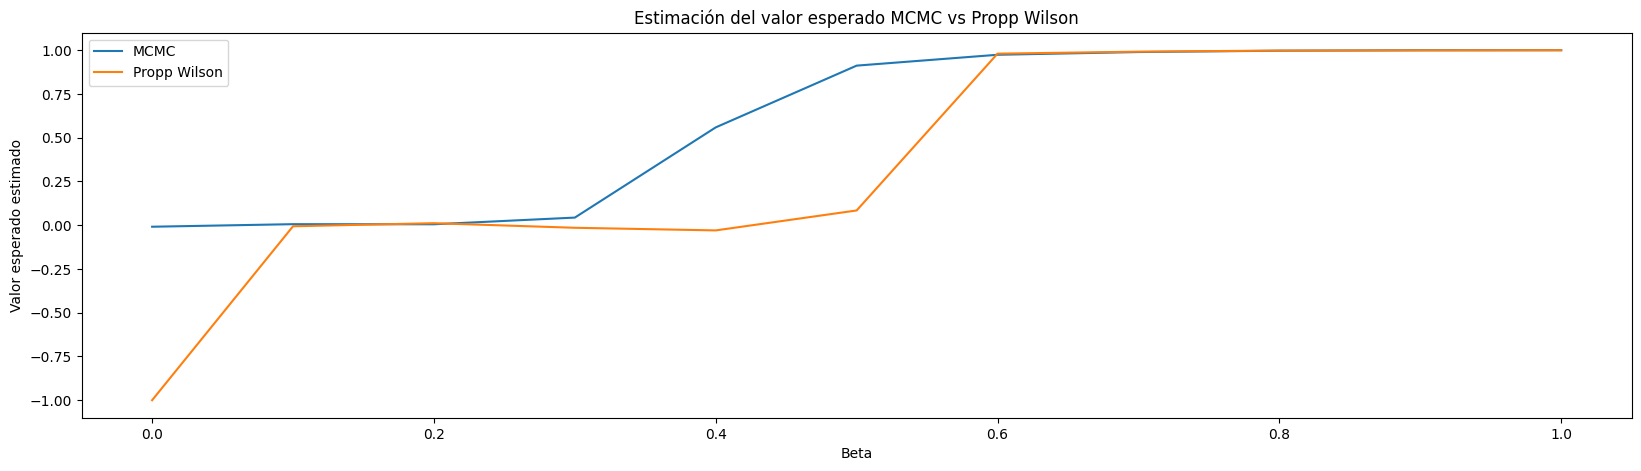

In [ ]:
mcmc = magnetization_per_beta(samples, betas, num_samples)
prowil = magnetization_per_beta(samples_pw, betas, num_samples)

graph_versus(mcmc,prowil,betas)

Note por ejemplo que en el valor de beta 0 tenemos que MCMC tiene un valor esperado estimado de 0 pero Propp Wilson de -1, esto debido a que para valor de energía 0 cualquier muestra funciona y en Propp Wilson consideramos la cota inferior. Hay unas discrepancias desde el valor 0.4 hasta el 0.5 pero a partir de 0.6 el comportamiento vuelve a ser similar y se mantiene.

In [ ]:
print(coalings)

[9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 

Ahora en cuanto al tiempo de coalecencia cómo puede apreciar en el print anterior, note que los tiempo de coalecencia tienden a 10000 que fue nuestra cota, es decir que lamentablemente se necesitaban más pasos para llegar a esa muestra exacta, aún así con cotas superiores el algoritmo toma horas en ejecutarse y cómo se mencionó antes con 1 millón luego de dos días completos de ejecución ni siquiera terminó.

#Punto 2


**PARTE A. Problema de la Hormiga (Recorrer todos los puntos y volver a (0,0))**

Primero es necesario descargar el archivo "in_points" y subirlo al colab en "Files" -> "Upload to session storage" en la parte izquierda del colab.

Link del archivo: https://drive.google.com/file/d/1E17V782vN22YfPFnjaJw6CeJ8ahckDGo/view?usp=sharing


El codigo consiste principalmente del $struct$ Annealing, el cual recibe como constructor dos funciones lambda, una de estas calcula el valor del siguiente estado ($see$) y la otra hace la actualizacion ($upd$).

Luego se corre por $x$ segundos llamando al metodo $sa.simulate(x)$

El fujo del proceso es el siguiente:

1. Leer los puntos originalmente del archvio **in_points**.
2. Correr el codigo en C++, el cual dara como resultado una permutacion en el archivo **out_points**.
3. Un script de python mostrara como era la permutacion de puntos original.
4. Un segundo script de python leera los puntos del archivo **out_points** y hace muestra visual.

**Algoritmo de energia**

Este algoritmo consiste de hacer "reverse" de un sub-segmento de la permutacion de puntos. En otras palabras, sea $P=[p_1,p_2,...,p_n]$ una permutacion dada.

$reverse(l,r)=[p_1,...,p_{l-1}]+[p_r,...,p_l]+[p_{r+1},...,P_{n}]$ para $l \leq r$.

Donde el operador $+$ hace referencia a concaternar los sub-segmentos.

Nota: El algoritmo tiene una modificacion que hace reverse en un arreglo circular, es decir, puede suceder que $l>r$. Entender por circular que despues de $p_n$ le sigue $p_1$. En tal caso toca hacer un reverse tomando [sufijo del arreglo + prefijo del arreglo]


Se observo que este algoritmo es mucho mas optimo que hacer $swap(p_l,p_r)$ dado que reduce la distancia entre estado y estado notando el siguiente ejemplo.

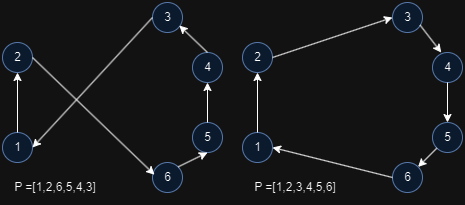

Desde el aspecto geometrico, se reduce la distancia al cambiar diagonales (lineas que se cruzan) en el camino dado. Si solo se realizara $swap(p_l,p_r)$, el anterior ejemplo le tomaria 2 iteraciones llevarnos al estado deseado.

$swap(p_3,p_6)$ resulta en $[1,2,3,5,4,6]$

$swap(p_4,p_5)$ resulta en $[1,2,3,4,5,6]$

Nota: Esta observacion tambien se le conoce como 2-opt.

Correr para crear el archivo en la VM:

In [ ]:
%%writefile SA.cpp


#include <bits/stdc++.h>

using namespace std;

#ifdef LOCAL
#include "../debug.h"
#define debug(...) cerr << "[" << #__VA_ARGS__ << "]:", debug_out(__VA_ARGS__)
#else
#define debug(...) 42
#endif

using ll = long long;
using lf = long double;
using my_clock = chrono::steady_clock;

struct Random {
	mt19937_64 engine;
	Random(): engine(my_clock::now().time_since_epoch().count()) {}
	template<class Int>Int integer(Int n) {return integer<Int>(0, n);} // `[0,n)`
	template<class Int>Int integer(Int l, Int r)
		{return uniform_int_distribution{l, r-1}(engine);} // `[l,r)`
	double real() {return uniform_real_distribution{}(engine);} // `[0,1)`
} random_generator;

struct Timer {
	using time = my_clock::time_point;
	time start = my_clock::now();
	double elapsed() { // Segundos desde el inicio.
		time now = my_clock::now();
		return chrono::duration<double>(now - start).count();
	}
} timer;

template<class See,class Upd>struct Annealing {
	using energy = invoke_result_t<See>;
	energy curr, low;
	See see;
	Upd upd;
	Annealing(See _see, Upd _upd): see{_see}, upd{_upd}
		{curr = low = see(), upd();}
	void simulate(double s, double mult=1) { // Simula por `s` segundos.
		double t0 = timer.elapsed();
		for (double t = t0; t-t0 < s; t = timer.elapsed()) {
			energy near = see();
			auto delta = double(curr - near);
			if (delta >= 0) upd(), curr = near, low = min(low, curr);
			else {
				double temp = mult * (1 - (t-t0)/s); //Temperature function
				if (exp(delta/temp) > random_generator.real()) upd(), curr = near;
			}
		}
	}
};

struct pt{ //Struct to store points
	lf x, y;
	pt(){}
	pt(lf X, lf Y): x(X), y(Y){}
	pt operator - (const pt & q){
		return pt(x - q.x, y - q.y);
	}
};

lf norm(pt p){ // Norm of a vector p
	return hypotl(p.x, p.y);
}

lf distance(pt a, pt b){ //Distance between point a and b
	return norm(b - a);
}

int main(){
	ios_base::sync_with_stdio(0); cin.tie(0);

  freopen("in_points","r",stdin);// read file
  freopen("out_points","w",stdout);// write file

	int n = 76; // there are 76 points
	vector<pt> a(n);// array of points

	for(int i=0; i<n; ++i){
		//read coordenates
		string sx, sy;
		cin >> sx >> sy;

		// Parse string to double in order to reduce float precision error
		lf x = stod(sx);
		lf y = stod(sy);
		a[i] = pt(x,y);
	}

	vector<int> permutation(n);
	iota(permutation.begin(),permutation.end(),0);
	int l , r;
	auto my_reverse = [&](int L, int R){ //Reverse function
		int len = 0;
		if( L < R ) len = R-L+1;
		else len = (n - L) + R + 1;
		for(int i=0; i<len/2; ++i){
			swap(permutation[L],permutation[R]);
			L++;
			R--;
			L += n;
			R += n;
			L%=n;
			R%=n;
		}
	};
	auto see = [&]{//Check next state and return "energy" or "value" of the next state

		l = random_generator.integer(0,n);
		r = random_generator.integer(0,n);

		my_reverse(l,r);// possible next state

		lf total_distance = 0;
		for(int i=0; i<n; ++i){
			int pi = permutation[i];
			int pi1 = permutation[(i+1)%n];
			total_distance += distance(a[pi],a[pi1]);
		}

		my_reverse(l,r);// go back to original state

		return total_distance;
	};

	auto upd = [&]{// Upd to next state
		my_reverse(l,r);
	};
	Annealing sa{see,upd};
	sa.simulate(60.0);// Run (x) seconds

  for(auto& i : permutation){
    cout << a[i].x << ' ' << a[i].y << '\n';// Print points in out_points file
  }
	return 0;
}


Overwriting SA.cpp


Compilar codigo de C++:

In [ ]:
! g++ SA.cpp -o SA

Ejecutar:

In [ ]:
! ./SA

Python script to plot points and lines.

First plot is the original path (non optimal)
Second plot is the answer path (supposed to be optimal)

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as pl

**CAMINO DE PERMUTACION ORIGINAL DADA (NO OPTIMO)**

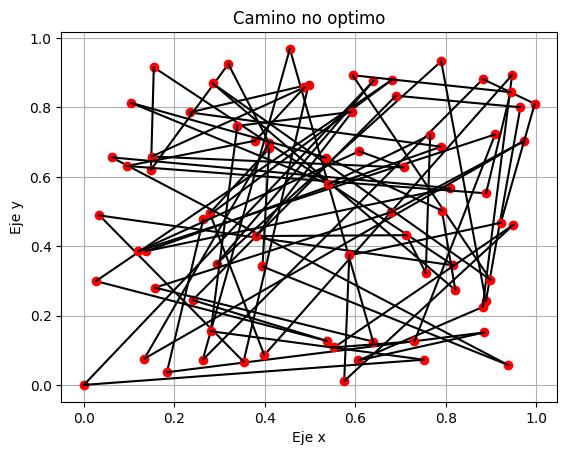

In [ ]:
points = []
n = 76 #Number of points

with open('in_points', 'r') as archivo:
    for linea in archivo:
        x, y = linea.strip().split() #Read points
        points.append([float(x),float(y)])

for i in range(n):
  pl.plot(points[i][0],points[i][1], 'ro')
  pl.plot([points[i][0],points[(i+1)%n][0]],[points[i][1],points[(i+1)%n][1]], 'k-')

pl.xlabel('Eje x')
pl.ylabel('Eje y')
pl.title('Camino no optimo')

pl.grid(True)
pl.show()

**CAMINO DE PERMUTACION RESULTANTE (IDEALMENTE OPTIMA)**

Distancia total recorrida:  7.079050736861958


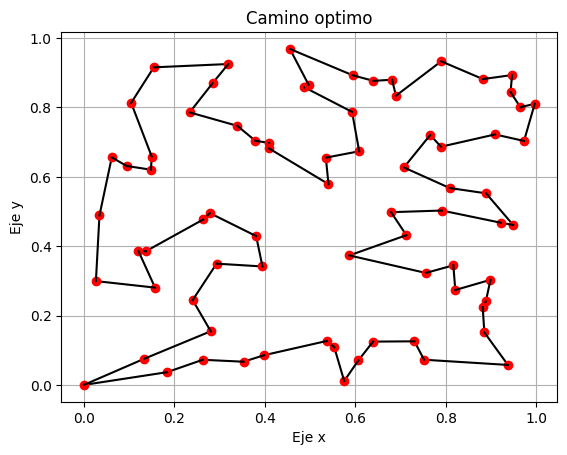

In [ ]:
points = []
n = 76 #Number of points

with open('out_points', 'r') as archivo:
    for linea in archivo:
        x, y = linea.strip().split() #Read points
        points.append([float(x),float(y)])

total_dis = 0.0
import math

for i in range(n):
  pl.plot(points[i][0],points[i][1], 'ro')
  pl.plot([points[i][0],points[(i+1)%n][0]],[points[i][1],points[(i+1)%n][1]], 'k-')
  dx = points[i][0] - points[(i+1)%n][0]
  dy = points[i][1] - points[(i+1)%n][1]
  total_dis += math.sqrt(dx * dx + dy * dy)
print("Distancia total recorrida: ",total_dis)
pl.xlabel('Eje x')
pl.ylabel('Eje y')
pl.title('Camino optimo')

pl.grid(True)
pl.show()

Se realizaron distintos experimentos para $time=1,5,10,20,40,60$ en segundos. Los resultados fueron los siguientes.

$Time=1$.

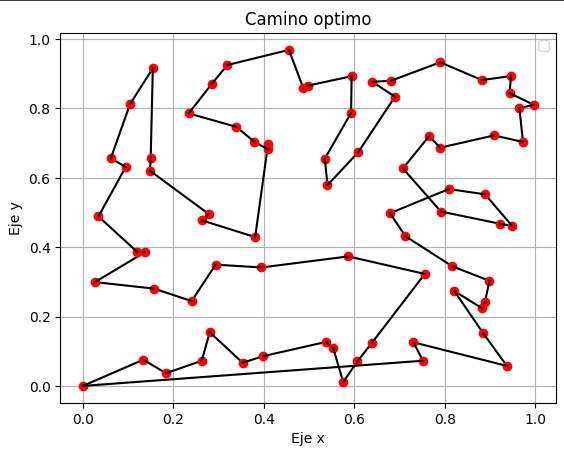

$Time=5$

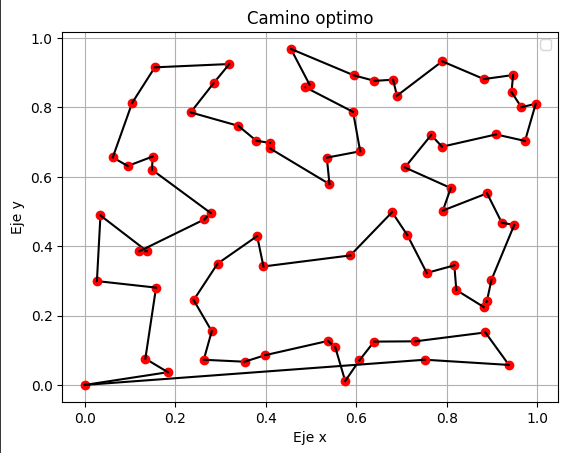

$Time=10$

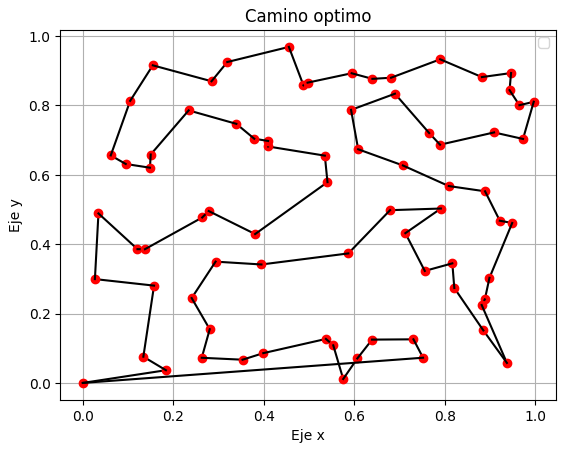

$Time=20$

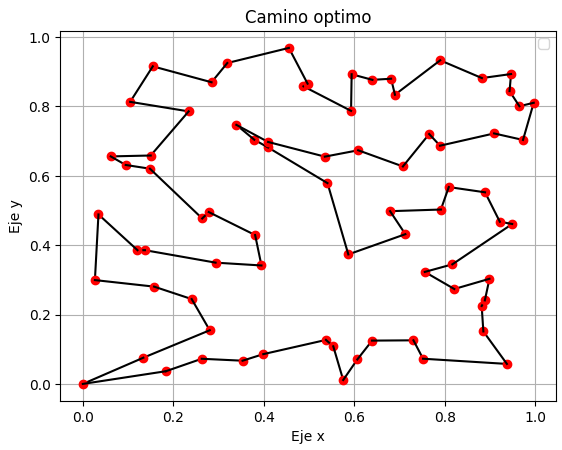

$Time=40$

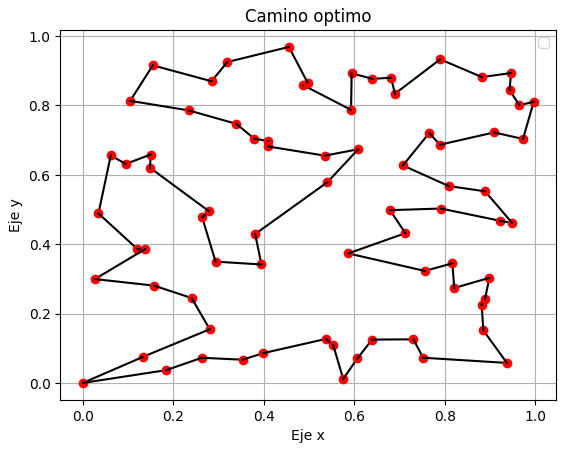

$Time=60$

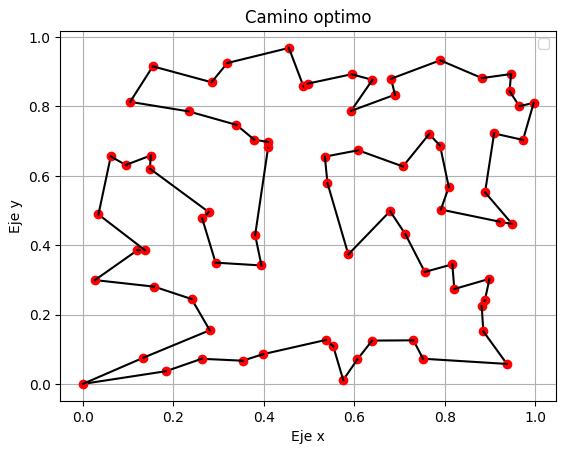

Vemos que entre $Time=40$ y $Time=60$ no son muchos lo cambios, asi que podemos concluir que en a lo mas 60 segundos tenemos una respuesta muy cercana a la deseada.

**PARTE B. Problema de la Hormiga (Recorrer todos los puntos sin volver a (0,0))**

La teoria para resolver esta parte B es la misma que la parte A con una modificacion en el algoritmo. En este ejercicio ya no se suma la distancia del ultimo punto en la permutacion con el punto origen (0,0).

In [ ]:
%%writefile SA2.cpp


#include <bits/stdc++.h>

using namespace std;

#ifdef LOCAL
#include "../debug.h"
#define debug(...) cerr << "[" << #__VA_ARGS__ << "]:", debug_out(__VA_ARGS__)
#else
#define debug(...) 42
#endif

using ll = long long;
using lf = long double;
using my_clock = chrono::steady_clock;

struct Random {
	mt19937_64 engine;
	Random(): engine(my_clock::now().time_since_epoch().count()) {}
	template<class Int>Int integer(Int n) {return integer<Int>(0, n);} // `[0,n)`
	template<class Int>Int integer(Int l, Int r)
		{return uniform_int_distribution{l, r-1}(engine);} // `[l,r)`
	double real() {return uniform_real_distribution{}(engine);} // `[0,1)`
} random_generator;

struct Timer {
	using time = my_clock::time_point;
	time start = my_clock::now();
	double elapsed() { // Segundos desde el inicio.
		time now = my_clock::now();
		return chrono::duration<double>(now - start).count();
	}
} timer;

template<class See,class Upd>struct Annealing {
	using energy = invoke_result_t<See>;
	energy curr, low;
	See see;
	Upd upd;
	Annealing(See _see, Upd _upd): see{_see}, upd{_upd}
		{curr = low = see(), upd();}
	void simulate(double s, double mult=1) { // Simula por `s` segundos.
		double t0 = timer.elapsed();
		for (double t = t0; t-t0 < s; t = timer.elapsed()) {
			energy near = see();
			auto delta = double(curr - near);
			if (delta >= 0) upd(), curr = near, low = min(low, curr);
			else {
				double temp = mult * (1 - (t-t0)/s);
				if (exp(delta/temp) > random_generator.real()) upd(), curr = near;
			}
		}
	}
};

struct pt{
	lf x, y;
	pt(){}
	pt(lf X, lf Y): x(X), y(Y){}
	pt operator - (const pt & q){
		return pt(x - q.x, y - q.y);
	}
};

lf norm(pt p){
	return hypotl(p.x, p.y);
}

lf distance(pt a, pt b){
	return norm(b - a);
}

int main(){
	ios_base::sync_with_stdio(0); cin.tie(0);

  freopen("in_points","r",stdin);// read file
  freopen("out_points","w",stdout);// write file

	int n = 76; // there are 76 points
	vector<pt> a(n);// array of points

	for(int i=0; i<n; ++i){
		//read coordenates
		string sx, sy;
		cin >> sx >> sy;

		// Parse string to double in order to reduce float precision error
		lf x = stod(sx);
		lf y = stod(sy);
		a[i] = pt(x,y);
	}

	vector<int> permutation(n);
	iota(permutation.begin(),permutation.end(),0);
	int l , r;
	auto my_reverse = [&](int L, int R){
		if( L > R ) swap(L,R);

		int len = R-L+1;

		for(int i=0; i<len/2; ++i){
			swap(permutation[L],permutation[R]);
			L++;
			R--;
		}
	};
	auto see = [&]{//Check next state and return "energy" or "value" of the next state

		l = random_generator.integer(1,n);
		r = random_generator.integer(1,n);


		my_reverse(l,r);// possible next state

		lf total_distance = 0;
		for(int i=0; i+1<n; ++i){
			int pi = permutation[i];
			int pi1 = permutation[i+1];
			total_distance += distance(a[pi],a[pi1]);
		}

		my_reverse(l,r);// go back to original state

		return total_distance;
	};

	auto upd = [&]{// Upd to next state
		my_reverse(l,r);
	};
	Annealing sa{see,upd};
	sa.simulate(60.0);

  for(auto& i : permutation){
    cout << a[i].x << ' ' << a[i].y << '\n';
  }
	return 0;
}


Overwriting SA2.cpp


In [ ]:
! g++ SA2.cpp -o SA2

In [ ]:
! ./SA2

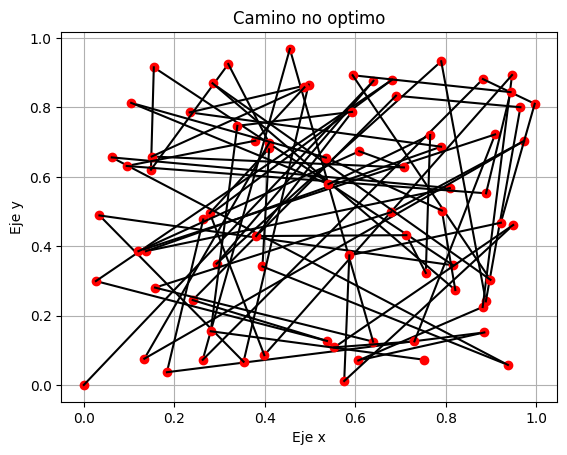

In [ ]:
points = []
n = 76 #Number of points

with open('in_points', 'r') as archivo:
    for linea in archivo:
        x, y = linea.strip().split() #Read points
        points.append([float(x),float(y)])

for i in range(n-1):
  pl.plot(points[i][0],points[i][1], 'ro')
  pl.plot([points[i][0],points[i+1][0]],[points[i][1],points[i+1][1]], 'k-')
pl.plot(points[n-1][0],points[n-1][1],'ro')

pl.xlabel('Eje x')
pl.ylabel('Eje y')
pl.title('Camino no optimo')

pl.grid(True)
pl.show()

Distancia total recorrida:  6.85759553679278


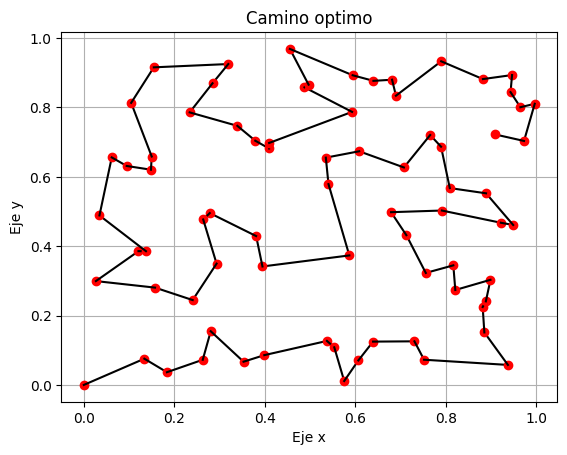

In [ ]:
points = []
n = 76 #Number of points

with open('out_points', 'r') as archivo:
    for linea in archivo:
        x, y = linea.strip().split() #Read points
        points.append([float(x),float(y)])

total_dis = 0.0
import math

for i in range(n-1):
  pl.plot(points[i][0],points[i][1], 'ro')
  pl.plot([points[i][0],points[i+1][0]],[points[i][1],points[i+1][1]], 'k-')
  dx = points[i][0] - points[i+1][0]
  dy = points[i][1] - points[i+1][1]
  total_dis += math.sqrt(dx * dx + dy * dy)
pl.plot(points[n-1][0],points[n-1][1], 'ro')

print("Distancia total recorrida: ",total_dis)

pl.xlabel('Eje x')
pl.ylabel('Eje y')
pl.title('Camino optimo')

pl.grid(True)
pl.show()